# Data analysis

In this notebook we will perform some simple analysis of the data.
We will look at some descriptive statistics, visualize the features in the data set and check for stationarity.

In [1]:
import matplotlib

import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from IPython.display import display

from data.get_50_highest_weights import get_sp_50_highest_weights_symbols
from data_preparation.ochlva_data import OCHLVAData
from utils.column_modifiers import keep_columns

C:\Users\michael.l.magnussen\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
matplotlib.use('nbAgg')
from utils.visualizations import plot_true_and_prediction

In [3]:
import matplotlib.pyplot as plt

Load the S&P 500 (as `^GSPC`) data

In [4]:
ochlva_data = OCHLVAData()

Load three other stocks of interest: The stock weighted the most, the medium weighted stock and the lowest weighted stock (out of the 50 downloaded).

In [5]:
symbols = get_sp_50_highest_weights_symbols()

# Select symbols with high, medium and low weights
selected_symbols = (symbols.iloc[0], 
                    symbols.iloc[len(symbols)//2], 
                    symbols.iloc[-1])

for s in selected_symbols:
    ochlva_data.load_data(s)

## Descriptive statistics

In [6]:
describing_column = 'Adj. Close'
columns = ['Samples', 'Start date', 'End date', 'NaNs', 'Mean', 'Max', 'Min', 'Std', 'Q1', 'Q2', 'Q3']
describing_dict = {col: list() for col in columns}
index = list()
for key in ochlva_data.raw_data.keys():
    index.append(key)
    description = ochlva_data.raw_data[key].describe()
    describing_dict['Samples'].append(int(description.loc['count', describing_column]))
    describing_dict['Start date'].append(str(ochlva_data.raw_data[key].index[0])[:10])
    describing_dict['End date'].append(str(ochlva_data.raw_data[key].index[-1])[:10])
    describing_dict['NaNs'].append(ochlva_data.raw_data[key].isnull().sum().sum())
    describing_dict['Mean'].append(description.loc['mean', describing_column])
    describing_dict['Max'].append(description.loc['max', describing_column])
    describing_dict['Min'].append(description.loc['min', describing_column])
    describing_dict['Std'].append(description.loc['std', describing_column])
    describing_dict['Q1'].append(description.loc['25%', describing_column])
    describing_dict['Q2'].append(description.loc['50%', describing_column])
    describing_dict['Q3'].append(description.loc['75%', describing_column])

display(pd.DataFrame(describing_dict, index=index)[columns])

,Samples,Start date,End date,NaNs,Mean,Max,Min,Std,Q1,Q2,Q3
^GSPC,1260,2013-03-07,2018-03-07,0,2079.750175,2872.870117,1541.609985,286.663626,1884.517517,2065.594971,2206.597473
AAPL,1254,2013-03-06,2018-02-28,0,106.716004,179.260000,50.928800,32.229902,85.194266,106.182039,122.349196
CMCSA,1258,2013-03-06,2018-03-06,0,29.283641,42.990000,18.031155,6.269263,24.920172,28.271251,33.938108
GILD,1259,2013-03-06,2018-03-06,0,79.645139,115.929959,41.946136,16.337412,69.417169,77.871612,94.513256


From the table, we can observe that:

1. The number of samples are almost the same, indicating that some trade days are missing for some of the stocks
2. There are no NaNs or 0s present
3. ^GSPC has values roughly one order of magnitude larger than the rest of the stocks

Note that the mean and standard deviation are the *sample* mean and standard deviation. 
I.e. it does not represent the true mean and standard deviation, at least not if the process is non-stationary. 

## Visulaizing features other than adjusted close

We will now investigate the ohlc data.
We will investigate the volume for itself, as the information in the volume data is of quite different character.

<IPython.core.display.Javascript object>


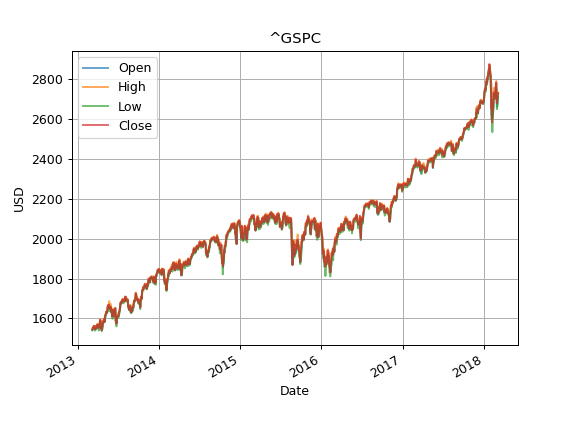

<IPython.core.display.Javascript object>


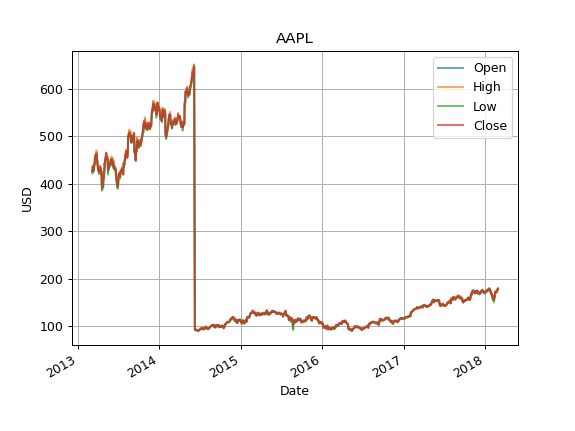

<IPython.core.display.Javascript object>


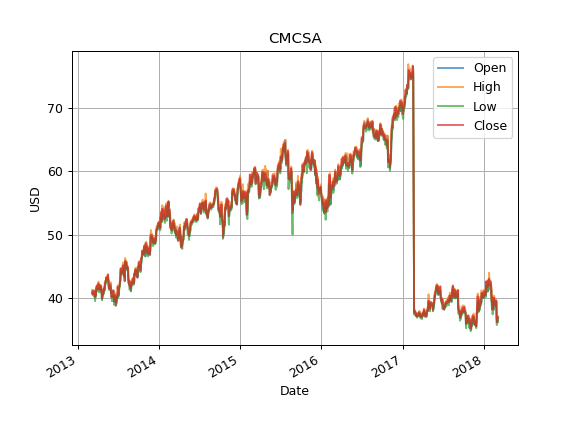

<IPython.core.display.Javascript object>


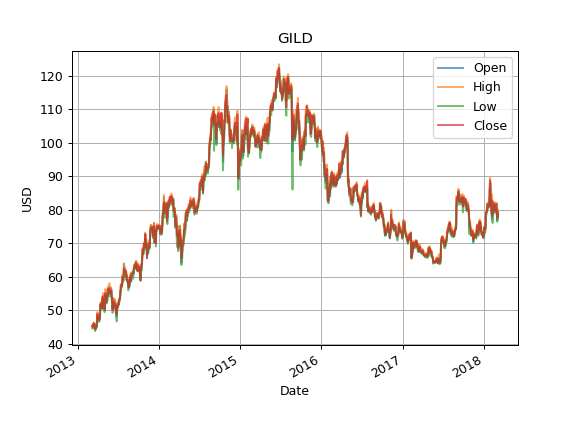

In [7]:
columns = ['Open', 'High', 'Low', 'Close']

for key in ochlva_data.raw_data.keys():
    ax = ochlva_data.raw_data[key].loc[:, columns].plot(alpha=0.7)
    _ = ax.set_ylabel('USD')
    ax.grid()
    ax.set_title(key)

plt.show()

From these plots we see that overall, the ochl values follow each other to a high degree.
It is important to note that they are not exactly the same, and in fact, how the open, high and low aligns with the closing value can give important hints about the closing value the next day.
The sudden drops are typical due to stock splits (which is accounted for in the adjusted close price).

We are now ready to investigate the volume of the stocks.

<IPython.core.display.Javascript object>


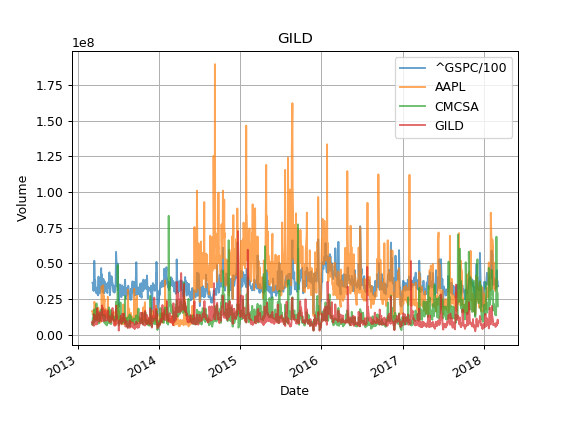

In [8]:

ax = (ochlva_data.raw_data['^GSPC'].loc[:, 'Volume']/100).plot(alpha=0.7)
_ = ochlva_data.raw_data['AAPL'].loc[:, 'Volume'].plot(alpha=0.7)
_ = ochlva_data.raw_data['CMCSA'].loc[:, 'Volume'].plot(alpha=0.7)
_ = ochlva_data.raw_data['GILD'].loc[:, 'Volume'].plot(alpha=0.7)
ax.legend([f'^GSPC/100', f'AAPL', f'CMCSA', 'GILD'])
_ = ax.set_ylabel('Volume')
ax.set_title(key)
ax.grid()

plt.show()

We observe that the volume does not follow the same trend as the ochl data, and has far less structure.
Note that the `^GSPC` volume has been divided by $100$ to make it easier to visually compare the results.

## Visualizing the training, validation and test set

For now, we will only be interested in training using the adjusted close values.

In [9]:
# Keep only 'Adj. Close' column
ochlva_data.transform(keep_columns, ['Adj. Close'], copy=False)

Next, we will plot the training, validation and test sets.

<IPython.core.display.Javascript object>


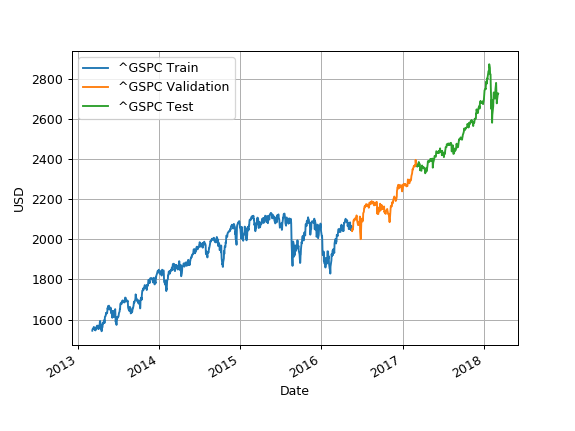

<IPython.core.display.Javascript object>


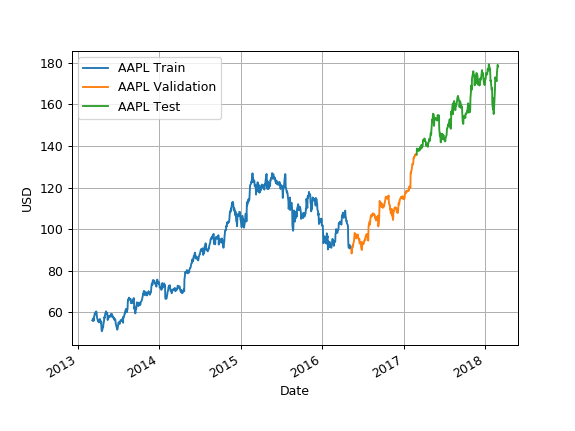

<IPython.core.display.Javascript object>


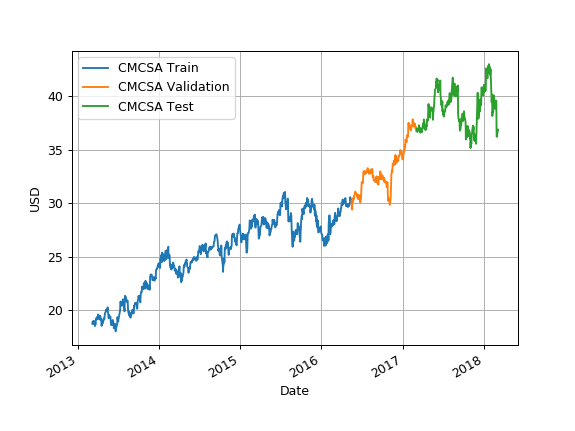

<IPython.core.display.Javascript object>


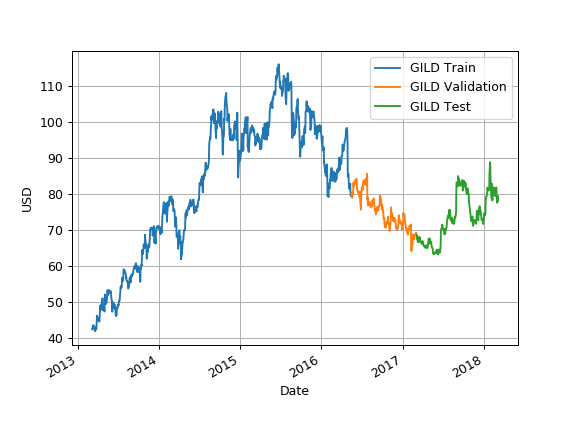

In [10]:
# Looping through the stocks
for key in ochlva_data.transformed_data.keys():
    x = ochlva_data.transformed_data[key]
    
    # Split the data
    x_train_full, x_test = \
        train_test_split(x, shuffle=False, test_size=.2)
    x_train, x_validate = \
        train_test_split(x_train_full, shuffle=False, test_size=.2)
    
    # Plot the train and test set
    ax = x_train.plot()
    _ = x_validate.plot(ax=ax)
    _ = x_test.plot(ax=ax)
    ax.legend([f'{key} Train', f'{key} Validation', f'{key} Test'])
    ax.grid()
    _ = ax.set_ylabel('USD')
    plt.show()

## Checking the non-stationary hypothesis

We will now check for non-stationarity for the set which visually apears the most stationary (i.e. the test set of the `CMCSA` stock).

We will use the [Augmented Dickey-Fuller](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)
test to test the probability that the time series contain a unit root and thereby is [trend-stationary](https://en.wikipedia.org/wiki/Trend_stationary), i.e. if the trend is removed, then the resulting data is stationary.
If the time series is trend-stationary it is at least not stationary.

The hypotheses are:

* Null hypothesis: The series are non-stationary (i.e. there exist an time dependent trend)
* Alternative hypothesis: The series is stationary (i.e. no trend exist)

Let us set the rejection hypothesis threshold of the p-value to $5 %$, meaning that we reject the null hypothesis (the series are stationary) if the p-value is less than or equal to $0.05$

In [11]:
x = ochlva_data.transformed_data['CMCSA']
_, x_test = train_test_split(x, shuffle=False, test_size=.2)
adf, p_value, _, _, critical_values, _ = adfuller(x_test.values.flatten())
print(f'ADF Statistic: {adf:.3}')
print(f'p-value: {p_value:.3}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'    {key}: {value:.3}')

ADF Statistic: -2.52
p-value: 0.11
Critical Values:
    1%: -3.46
    5%: -2.87
    10%: -2.57


As $p > 0.05$ we can see that there is no evidence to reject the null hypothesis.
In other words, the time series is probably non-stationary.